<h1 align='center'> Uncertainty in Solar Energy Generation</h1>

Paulo Soares November 16, 2020 <br> Penn State University <br> Coded in Python 3.7.9 using Jupyter Notebook

### 0. Disclaimer

This notebook illustrates the value of incorporating measured solar irradiance data, sourced from accurate radiometric station, to provide uncertainty analysis in solar photovoltaic (PV) generation models. Most of the PV design tools rely on TMY data (short for typical meteorological year) which is not designed with the solar energy applications in mind (it shows a typical <b>meteorological</b> year and not a typical <b>solar</b> year. Or, as Frank Vignola (2012) puts it:

<i>"To develop a sound, bankable dataset, it is important to understand resource variability and the nature of uncertainties in the various constituents of the data ...  TMY files may be suitable for initial evaluations, they generally do not constitute a bankable dataset."</i> Moreover, <i>"...if the TMY file is used to estimate the performance of a solar system, comparisons between the long-term dataset and the TMY averages should be carried out. This is especially true for TMY3 data files created from just 11 years of data."</i>
    
Vignola, Frank E., Andrew C. McMahan, and Catherine N. Grover. "Bankable solar-radiation datasets." Solar Energy Forecasting and Resources Assessment (2013).    

####  IF YOU ARE RUNNING THIS THROUGH THE WEB (USING BINDER) READ BELOW!  

<li> 1) Do not download files from NOAA </li>
<li> 2) When prompted to insert a start and end year, use 2015 and 2019 </li>
<li><b> 3) Load the data set at the end of section 4</b> </li>

### 1. Python Packages

Here I'm calling the required packages to make this code run. 

In [1]:
# Required packages to run the Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import pytz
import pvlib
import glob
from ftplib import FTP
import os, sys, os.path

In [2]:
## Here we're adjusting how we want our graphics to be displayed ##
#
#Matplotlib options
from matplotlib.dates import DateFormatter
plt.rcParams['figure.figsize'] = [12.0, 5.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'large'

### 2. Download data from NOAA FTP Server

For measuring the uncertainty in the solar PV generation modeling we need reliable solar irradiance data preferably sourced from a radiometric station located close to the site being modeled. <br>

In this example we will be collecting and using data from the NOAA SURFRAD station in State College, PA. <br>

<i>"...the Surface Radiation Budget Network (SURFRAD) was established in 1993 through the support of NOAA's Office of Global Programs. The SURFRAD mission is clear; its primary objective is to support climate research with accurate, continuous, long-term measurements of the surface radiation budget over the United States." </i>

Visit: https://www.esrl.noaa.gov/gmd/grad/surfrad/overview.html

<ui>Here we have:
<li> 5 years of data </li>
<li> Data sampled every minute  </li>
<li> Data include the global horizontal irradiance (GHI), diffuse horizontal irradiance (DHI), direct normal irradiance (DNI), air temperature, and ambient pressure </li>
    <li> <b>IF USING BINDER: The data was averaged to 10 min to save storage and computational time</b></li>   
</ui>


In [3]:
#Defining the range of data to be downloaded

first_year = input("Type the first year of the data series (in YYYY): ")
first_year = int(first_year)
last_year = input("Type the last year of the data series (in YYYY): ")
last_year = int(last_year)
last_year = last_year+1
years = np.arange(first_year,last_year,1).astype(str)

#Download data from NOAA's FTP server - Or not
download = input("Type 1 to download data from NOAA server or 0 to skip: ")
download = int(download)
if download != 0:
    
    for year in years:
        ftp = FTP('aftp.cmdl.noaa.gov') # get filenames within the directory

        ftp.login()

        ftp.cwd('data/radiation/surfrad/Penn_State_PA/'+year+'/')
        filenames = ftp.nlst() 

    #print(filenames)

    for filename in filenames:
        local_filename = os.path.join('../Data/NOAA/', filename)
        file = open(local_filename, 'wb')
        ftp.retrbinary('RETR '+ filename, file.write)

        file.close()

    ftp.quit() # This is the “polite” way to close a connection
    
    #Concatenating data into a Single File
    interesting_files = glob.glob('../Data/NOAA/*.dat') 
    #print(interesting_files)
    df_list = []
    for filename in sorted(interesting_files):
        df_list.append(pd.read_csv(filename,skiprows=2,delim_whitespace=True, header=None))
    full_df = pd.concat(df_list)
    #Save raw data
    full_df.to_csv('../Data/NOAA/output-full_raw_'+year+'.csv')
    
    #Removing Original Files
    for f in interesting_files:
        os.remove(f)    
    
    print("Donwload finished. Proceed to the next cell.")
    
else:
    print("Download Skipped. Proceed to the next cell.")

Type the first year of the data series (in YYYY):  2015
Type the last year of the data series (in YYYY):  2019
Type 1 to download data from NOAA server or 0 to skip:  0


Download Skipped. Proceed to the next cell.


### 3. Create a Single Data File

In [5]:
#Concatenating the DataFrames into a single DF

online = input('Are you working online? (Y/N): "')

if online == 'N' or online == 'n':
    data = pd.DataFrame()
    headers = np.arange(0,48,1)

    for year in years:
        dat = pd.read_csv('../Data/NOAA/output-full_raw_'+year+'.csv', sep=',', skiprows=0, header = 0, names = headers, index_col=0)
        data = data.append(dat)
else:
    print("SKIP to the end of section 4.")
    

Are you working online? (Y/N): " y


SKIP to the end of section 4.


In [ ]:
#Saving the raw data - if desired
saved = input("Do you want to save the raw data file? (Y/N): ")

if saved == 'Y' or saved == 'y':
    data.to_csv('../Data/NOAA/output_'+years[0]+'_to_'+years[-1]+'_raw.csv')
else:
    print("No action taken. Proceed to the next cell.")

### 4. Extracting Interesting Data
For more information on how to read NOAA SURFRAD data files, please  download this document from the NOAA server:</p>
ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/Penn_State_PA/READMEftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/Penn_State_PA/README 

In [ ]:
# Loading the files
df = data
# # Renaming interesting columns
df = df.rename(index=str, columns={0: 'Year', 1:'jday', 2: 'Month',3: 'Day',4: "Hour", 5: 'Min',6:'dt', 7:'Zenith_deg',
                                   8: 'Global_Wm2',10:'uw_solar', 12: 'Direct_Wm2',14:'Diffuse_Wm2',16:'dw_ir',18:'dw_casetemp',
                                   20:'dw_dometemp',22:'uw_ir',24:'uw_casetemp',26:'uw_dometemp',28:'uvb',30:'par',32:'netsolar',
                                   34:'netir',36:'totalnet',38:'Temp_C',40:'rh',42:'windspd',44:'winddir',46:'pressure'}) 
# #Working with only interesting data
df = df[['Year', 'Month', 'Day', 'Hour', 'Min', 'rh', 'Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2', 'Temp_C', 'pressure']]
# #Next steps set the data frame index as type datetime
df['date'] = df.Year.map(str)+'-'+df.Month.map(str)+'-'+df['Day'].map(str)+' '+df['Hour'].map(str)+':'+ df['Min'].map(str)
index = pd.DatetimeIndex(df.date)
df = df[['Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2', 'Temp_C', 'rh', 'pressure']]
df = df.set_index(index)

##### 4.1. Data Quality Assessment

In [ ]:
## Removing negative and absurd values from the data set, if any
#Negative values
df.Global_Wm2[df.Global_Wm2 <= 0] = 0
df.Temp_C[df.Temp_C <= -40] = 0
df.Direct_Wm2[df.Direct_Wm2 <= 0] = 0
df.Diffuse_Wm2[df.Diffuse_Wm2 <= 0] = 0
df.rh[df.rh <= 0] = 30

#Absurd values
df.Global_Wm2[df.Global_Wm2 > 1500 ]= np.nan
df.Direct_Wm2[df.Direct_Wm2 > 1500] = np.nan
df.Diffuse_Wm2[df.Diffuse_Wm2 > 1500 ]= np.nan
df.Temp_C[df.Temp_C > 40 ]= np.nan
df.rh[df.rh > 100 ]= np.nan

df = df.dropna()
#Quick statistics
df.describe()

##### 4.2. IF USING BINDER LOAD THE DATA HERE!

In [7]:
# - if desired
loaded = input("Do you want to save the raw data file? (Y/N): ")

if loaded == 'Y' or loaded == 'y':
    df = pd.read_csv('../Data/NOAA/output_2015_to_2019_ready.csv', sep=',', parse_dates=True, index_col=0)
else:
    print("No action taken. Proceed to the next cell.")

Do you want to save the raw data file? (Y/N):  y


### 5. Solar irradiance data analysis

Here we examine the behavior of the solar irradiance data for the selected period (2015-2019). 


HEADS UP!<p>
<b>Solar irradiance </b> is the instantaneous flux of energy in <b><i>W/m$^{2}$</i></b>

<b>Solar irradiation </b> is the summation of the instantaneous flux of solar energy (irradiance) over a period of time, in <b><i>J/m$^{2}$</i></b> or in <b><i>kWh/m$^{2}$</i></b>

In [8]:
#From irradiance to energy (times 60 the energy received from the Sun during that minute) - We will change the headers later
df_mi = df[['Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2']]*60*10 # J/m2
df_mw = df[['Temp_C', 'rh', 'pressure']]

In [9]:
#Resampling the data - Summing the energy data, averaging the weather data - and concatenanting the files
df1 = df_mi.resample('D').sum()
df1 = df1/3.6e6  # to convert from J/m2 to kWh/m2
df2 = df_mw.resample('D').mean()

df_mon = pd.concat([df1, df2], axis=1) # Concatenating
ind = pd.DatetimeIndex(df_mon.index) #adjusting the index
df_mon = df_mon.set_index(ind)

df_month = df1.groupby(by=[df1.index.month]).mean() #average values
df_month_e = df1.groupby(pd.Grouper(freq='M')).std() #dispersion

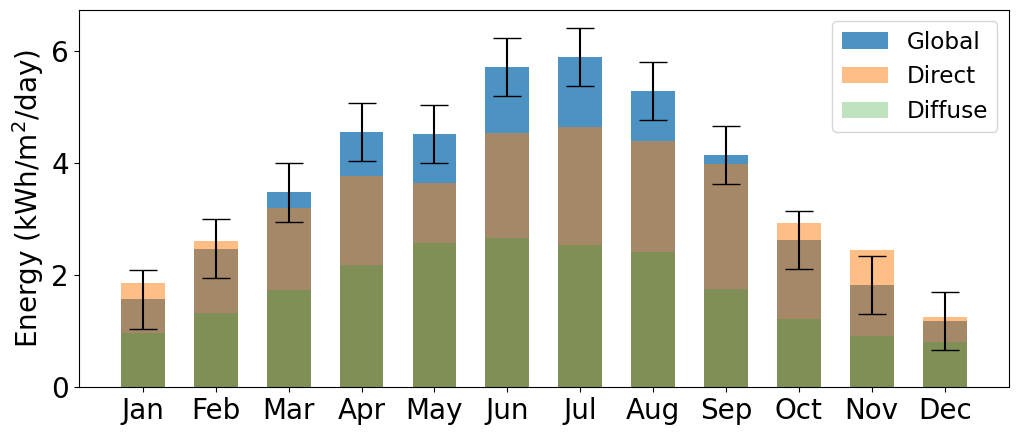

In [10]:
#Create a bar plot to better visualize previous results
N = 12 #months
labels = ['Jan', 'Feb','Mar', 'Apr','May', 'Jun','Jul', 'Aug','Sep', 'Oct','Nov', 'Dec']

#Preparing the plot
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
width = 0.6       # the width of the bars

#Plotting the bars
ax.bar(ind, df_month.Global_Wm2, width, yerr=df_month_e.Global_Wm2.std(), capsize=10, align='center', alpha=0.8)
ax.bar(ind, df_month.Direct_Wm2, width, alpha=0.5)
ax.bar(ind, df_month.Diffuse_Wm2, width, alpha=0.3)


#Finishing...
ax.set_ylabel('Energy ' r'(kWh/m$^2$/day)')
ax.set_xticks(ind)
ax.set_xticklabels(labels)

plt.legend(['Global', 'Direct','Diffuse'])

#Saving
#plt.savefig('Results/scatter_good2.jpg')
plt.show()

Solar Irradiance components charts -  type: 1 for GHI, 2 for DNI, 3 for DHI. To skip press any other key:  1


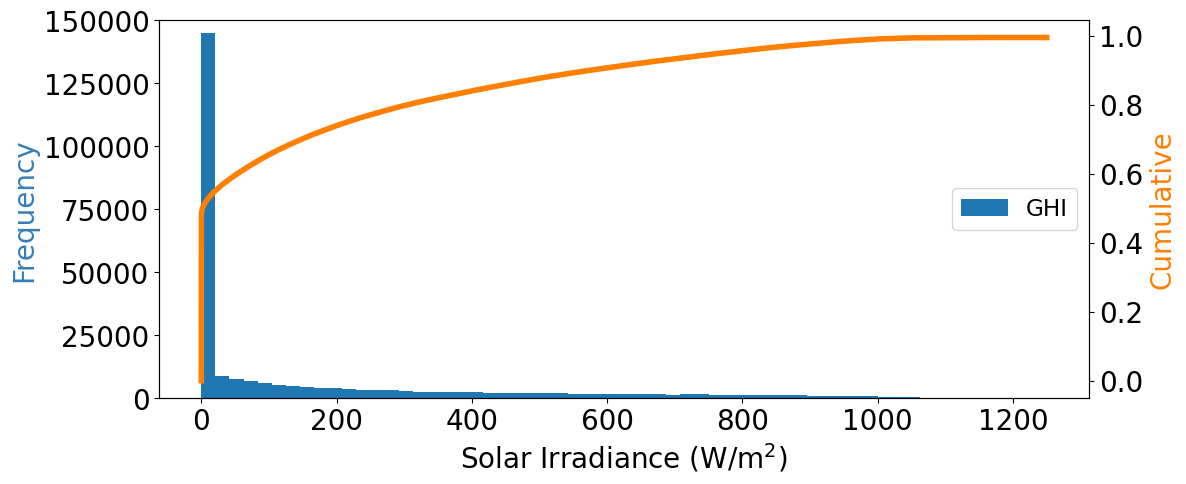

In [11]:
#Histograms and cummulative distributions - if desired
from statsmodels.distributions.empirical_distribution import ECDF
comp = input("Solar Irradiance components charts -  type: 1 for GHI, 2 for DNI, 3 for DHI. To skip press any other key: ")

if comp == '1' or comp == '2' or comp == '3':
    if comp == '1':
        key = 'Global_Wm2';leg = 'GHI'
    if comp == '2':
        key = 'Direct_Wm2';leg = 'DNI'
    if comp == '3':
        key = 'Diffuse_Wm2'; leg = 'DHI'        


    ecdf = ECDF(df[key])
    fig, ax1 = plt.subplots()

    color = '#377eb8'
    ax1.set_xlabel('Solar Irradiance (W/m$^2$)')
    ax1.set_ylabel('Frequency', color=color)
    ax1.set_ylim(0,150000)
    ax1.hist(df[key], bins=60)
    ax1.legend([leg], loc='center right')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = '#ff7f00'
    ax2.set_ylabel('Cumulative', color=color)  # we already handled the x-label with ax1
    ax2.plot(ecdf.x, ecdf.y, color=color, linewidth=4)
else:
    print('You could have seen an amazing graph. You missed your chance!')

### 6. Solar PV Generation

<b>Using the PVLib Python package: </b><p>

<i>"...pvlib python is a community supported tool that provides a set of functions and classes for simulating the performance of photovoltaic energy systems. pvlib python was originally ported from the PVLIB MATLAB toolbox developed at Sandia National Laboratories and it implements many of the models and methods developed at the Labs. pvlib python is a community supported tool that provides a set of functions and classes for simulating the performance of photovoltaic energy systems. pvlib python was originally ported from the PVLIB MATLAB toolbox developed at Sandia National Laboratories and it implements many of the models and methods developed at the Labs."</i><p>
    
For more information visit:    
https://pvlib-python.readthedocs.io/en/v0.8.0/index.html

#### 6.1. Preparing the Data

In [12]:
###### Loading PVLib packages 
import pvlib.pvsystem 

import pvlib.solarposition

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain, basic_chain

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [13]:
# Resampling the original data set to hourly values.
df = df.resample('H').mean()
#Calculating solar azimuth and zenith angles - This is just to test the accuracy of the PVLib solar position algorithm
lat = 40.72 # State College NOAA Surfrad Station latitude
long = -77.93 # State College NOAA Surfrad Station longitude
alt=376
new2 = pvlib.solarposition.get_solarposition(df.index, latitude=lat, longitude=long, altitude=alt , pressure=df.pressure, temperature=df.Temp_C)
df = pd.concat([df, new2[['azimuth','zenith']]], axis=1)

In [16]:
# Removing nighttime values from the df - if desired

day = input("Do you want to work with daytime values only? (Y/N): ")

if day == 'Y' or day == 'y':
    df.Zenith_deg[df.Zenith_deg > 85] = np.nan
    df = df.dropna()
    df.describe()
    print("Working with daytime values only.")
else:
    print("Working with nighttime + daytime values.")

Do you want to work with daytime values only? (Y/N):  n


Working with nighttime + daytime values.


In [17]:
#Saving the hourly data set - if desired
saved = input("Do you want to save the processed data file? (Y/N): ")

if saved == 'Y' or saved == 'y':
    df.to_csv('../Data/NOAA/output_'+years[0]+'_to_'+years[-1]+'_hourly.csv')
else:
    print("No action taken. Proceed to the next cell.")

Do you want to save the processed data file? (Y/N):  n


No action taken. Proceed to the next cell.


#### 6.2. PV Generation Model

In [18]:
###### PV system specs ######

#Number of modules
N_mod = input("Enter the number of the PV modules of the system example: 26): ")
N_mod = int(N_mod)
#Number of inverters
N_inv = input("Enter the number of the inverters of the system (example: 1): ")
N_inv = int(N_inv)

#Site Characteristics
lat,long = input("Enter the site latitude and longitude in decimal degrees (example: 40.72,-77.84): "  ).split(",")
lat = float(lat)
long= float(long)
alt = input("Enter the site altitude in METERS (example: 376.0): " )
alt = float(alt)
surface_tilt, surface_azimuth = input("Enter the [tilt, azimuth] angles of the PV system in degrees (example: 30, 180 ): "  ).split(",")
surface_tilt = float(surface_tilt)
surface_azimuth = float(surface_azimuth)

Enter the number of the PV modules of the system example: 26):  26
Enter the number of the inverters of the system (example: 1):  1
Enter the site latitude and longitude in decimal degrees (example: 40.72,-77.84):  40.72,-77.84
Enter the site altitude in METERS (example: 376.0):  376.0
Enter the [tilt, azimuth] angles of the PV system in degrees (example: 30, 180 ):  30, 180


In [19]:
## load some module and inverter specifications - NEEDS some refinement
# CEC modules list
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
# Selecting a module manufacturer and type
cec_module = cec_modules['SunPower_SPR_E20_327'] 

# CEC inverters list
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
# Selecting an inverter manufacturer and type
#Examples: #SMA_America__SB3800TL_US_22__208V_ / SunPower__SPR_E20_327_C_AC__208V_ / SMA_America__SB7700TL_US_22__240V_
cec_inverter = cec_inverters['SMA_America__SB7700TL_US_22__240V_']

In [20]:
# Using PVLib Model Chain To calculate the AC Power. For more information visit: https://pvlib-python.readthedocs.io/en/v0.8.0/modelchain.html

location = Location(latitude=lat, longitude=long)

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                  module_parameters=cec_module,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters, modules_per_string=N_mod/N_inv, 
                  strings_per_inverter=N_inv, altitude=alt)# Ex. 26 modules in 2 inverters:  modules_per_string=13, strings_per_inverter=2


mc = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")

weather = df[['Direct_Wm2', 'Global_Wm2', 'Diffuse_Wm2', 'Temp_C']]
weather = weather.rename(index=str, columns={'Direct_Wm2':'dni', 'Global_Wm2':'ghi', 'Diffuse_Wm2':'dhi', 'Temp_C':'temp_air'})
index = pd.DatetimeIndex(weather.index)
weather = weather.set_index(index)

print(mc)

C:\Users\PauloHenrique\Anaconda3\lib\site-packages\pvlib\pvsystem.py:222: pvlibDeprecationWarning: Arbitrary PVSystem kwargs are deprecated and will be removed in v0.9
  'removed in v0.9', pvlibDeprecationWarning


ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [21]:
# Running the model
mc.run_model( weather=weather);

#### 6.3. Visualizing the results

In [22]:
# Saving the modeled AC Power and converting from Wh to kWh
mc_ac = pd.DataFrame(list(mc.ac), columns={'AC_Power'}, index=df.index)
mc_ac.AC_Power[mc_ac.AC_Power < 0] = 0 #setting negative values to 0 
mc_ac = mc_ac/1000 # in kWh

##### 6.3.1. Monthly analysis

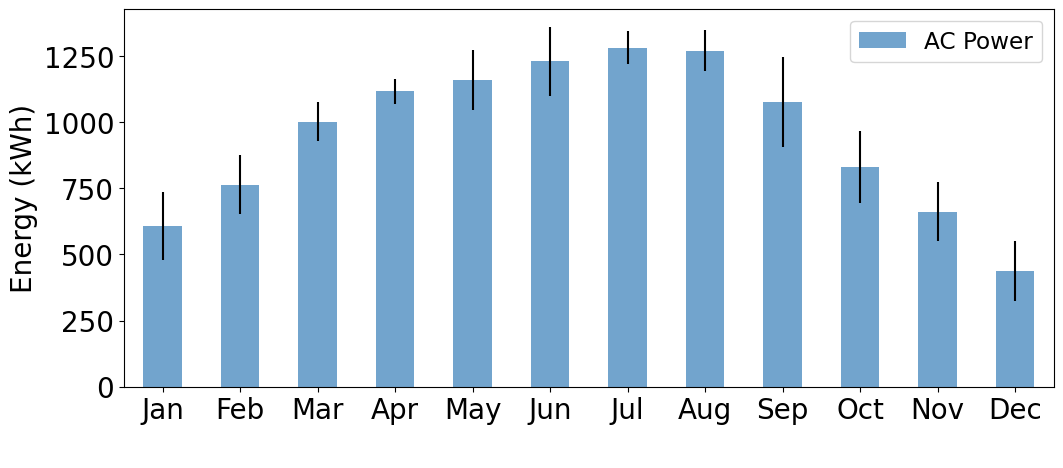

In [23]:
mc_acM = mc_ac.resample('M').sum()

# Let's viusalize the statistics
x = np.linspace(1,13,1)
fig, ax = plt.subplots()

mc_acM.groupby(mc_acM.index.month).mean().plot.bar(rot=0, ax=ax, color='#377eb8', alpha = 0.7, yerr=mc_acM[['AC_Power']].groupby(mc_acM.index.month).std())

ax.set_ylabel('Energy (kWh)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax.legend(["AC Power"], loc='best')
#plt.savefig('../Results/MeanProdDif.pdf')
plt.show(block=True)

In [24]:
# Main Statistics
mc_acM.describe()

,AC_Power
count,60.000000
mean,953.141191
std,292.659831
min,311.818092
25%,744.596515
50%,1026.792167
75%,1171.062586
max,1358.611794


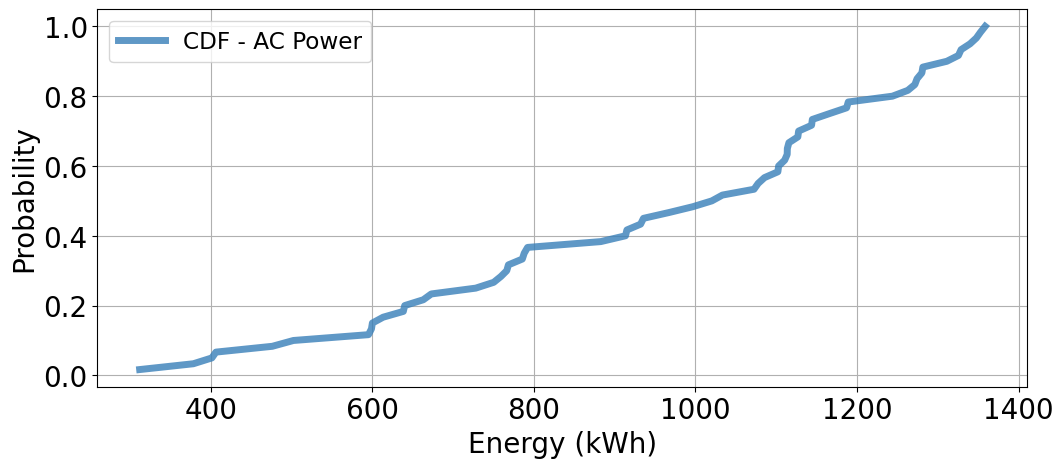

In [25]:
# Checking the probabilities of generation dropping below a certain value
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(mc_acM.AC_Power)

fig, ax = plt.subplots()

ax.plot(ecdf.x, ecdf.y, linewidth = 5.0, color='#377eb8', alpha=0.8)

ax.set_ylabel('Probability')
ax.set_xlabel('Energy (kWh)')
ax.grid()
ax.legend(["CDF - AC Power"], loc='best')

In [26]:
# Aiding the readability of the graph
sample = mc_acM['AC_Power']
n = len(sample)
sort = sorted(sample)
print('There is a 10% probability of having less than', "{0:.2f}".format(sort[int(n * 0.1)])+' kWh generated on a given month.')
print('There is a 50% probability of having less than', "{0:.2f}".format(sort[int(n * 0.5)])+' kWh generated on a given month.')
print('There is a 90% probability of having less than', "{0:.2f}".format(sort[int(n * 0.9)])+' kWh generated on a given month.')

There is a 10% probability of having less than 595.13 kWh generated on a given month.
There is a 50% probability of having less than 1033.37 kWh generated on a given month.
There is a 90% probability of having less than 1325.54 kWh generated on a given month.


##### 6.3.1. Yearly analysis

In [27]:
# Expected PV generation through the years - in kWh
power_year = mc_ac.resample('Y').sum() # also could have used the command: mc_ac.groupby(mc_ac.index.year).sum()
power_year

,AC_Power
date,
2015-12-31,11732.889823
2016-12-31,11932.900854
2017-12-31,11491.928605
2018-12-31,10565.318942
2019-12-31,11465.433262


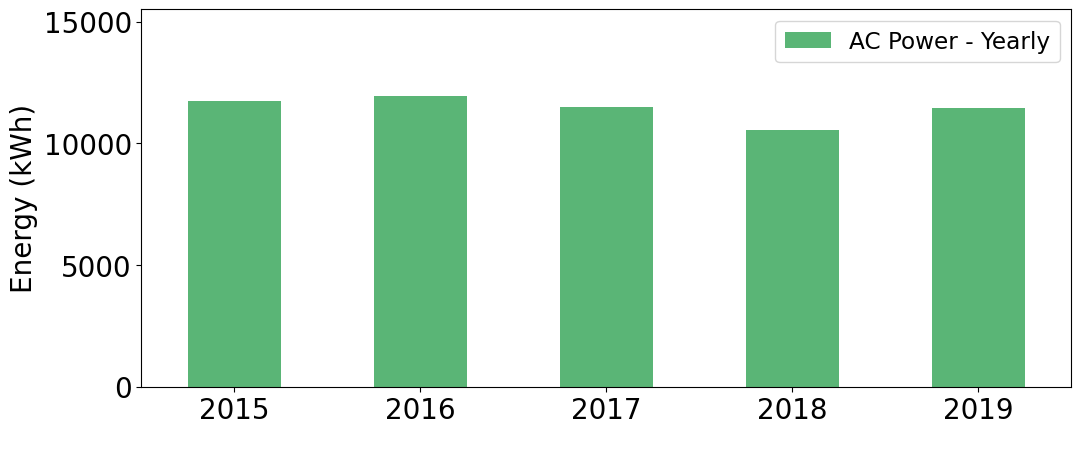

In [28]:
# Visualizing the previous dataframe
fig, ax = plt.subplots()

power_year.AC_Power.plot.bar( rot=0, color='#31a354', alpha = 0.8)

ax.set_ylabel('Energy (kWh)')
ax.set_xlabel(' ')
ax.set_ylim(0,max(power_year.AC_Power)*1.3)
ax.set_xticklabels(years)

ax.legend(["AC Power - Yearly"], loc='best')

### 7. Comparing models: Measured data X TMY data

In [ ]:
# Loading the TMY file - Got lazy and used the TMY file processed by NREL System Advisor Model (SAM)
tmy_weather = pd.read_csv('../Data/TMY/StateCollege_NSRDB_TMY.csv')
# # #Working with only interesting data
tmy_weather  = tmy_weather [['dni', 'ghi', 'dhi', 'wind_speed', 'temp_air']]
index = pd.date_range(start='1/1/2015 00:00', end='12/31/2015 23:00', freq='H')
tmy_weather = tmy_weather.set_index(index)
tmy_weather.describe()

In [ ]:
mc2 = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")
mc2.run_model( weather=tmy_weather);

In [ ]:
# Saving the modeled AC Power and converting from Wh to kWh
mc_ac_tmy = pd.DataFrame(list(mc2.ac), columns={'AC_Power'}, index=tmy_weather.index)
mc_ac_tmy.AC_Power[mc_ac_tmy.AC_Power < 0] = 0 #setting negative values to 0 
mc_ac_tmy = (mc_ac_tmy)/1000 # in kWh

In [ ]:
mct = mc_ac_tmy.resample('M').sum()

# Let's viusalize the statistics
x = np.linspace(1,13,1)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

mct.groupby(mct.index.month).mean().plot.bar(rot=90, ax=ax, label='_nolegend_', color='#ff7f00', alpha = 0.7)

mc_acM.groupby(mc_acM.index.month).mean().plot.bar(rot=90, ax=ax2, color='#377eb8', alpha=0.7,
                                                   yerr=mc_acM[['AC_Power']].groupby(mc_acM.index.month).std(), label='_nolegend_')

ax.set_ylabel('AC Energy (kWh)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax.legend(["TMY"], loc='best')

ax2.set_xlabel(' ')
ax2.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax2.legend(["NOAA"], loc='best')
#plt.savefig('../Results/MeanProdDif.pdf')
plt.show(block=True)

### 8. Not Used - Saving for future reference

In [ ]:
# load some module and inverter specifications - NEEDS some refinement
# cec_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# cec_module = {'STC':327.106,'PTC':302.9,'A_c':1.63,'Length':1.559,'Width':1.046,'N_s':96,'I_sc_ref':6.46,'V_oc_ref':64.9,'I_mp_ref':5.98,
# 'V_mp_ref':54.7,'alpha_sc':0.002196,'beta_oc':-0.175879,'T_NOCT':46.2,'a_ref':2.464016,'I_L_ref':6.470243,'I_o_ref':2.26523E-11,'R_s':0.417205,
# 'R_sh_ref':263.136993,'Adjust':11.129273,'gamma_r':-0.36,'Cells_in_Series':96,'Parallel_Strings':1,'Isco':6.46,'Voco':64.9,'Impo':5.98,
# 'Vmpo':54.7,'Aisc':0.002196,'Aimp':-0.00038,'C0':1.009,'C1':-0.009,'Bvoco':-0.177,'Mbvoc':0,'Bvmpo':-0.186,'Mbvmp':0,'N':1.131,'C2':0.3802,
# 'C3':-3.716,'A0':0.9597,'A1':0.03217,'A2':-0.00366,'A3':0.00006,'A4':0.0000054,'B0':1,'B1':-0.006987,'B2':0.000862,'B3':-0.000034,'B4':0.000000535,
# 'B5':-2.99E-09,'DTC':3,'FD':1,'C4':0.988,'C5':0.012,'IXO':6.08,'IXXO':4.25,'C6':1.093,'C7':-0.093}

# cec_inverter = cec_inverters['SMA_America__SB3800TL_US_22__208V_']#SMA_America__SB3800TL_US_22__208V_ ? SunPower__SPR_E20_327_C_AC__208V_

In [ ]:
# Not used - ignore
# yes = pvlib.modelchain.basic_chain(times=df.index,latitude=lat, longitude=long, aoi_model="no_loss",irradiance=weather, 
#                   module_parameters=cec_module, inverter_parameters=cec_inverter, modules_per_string=13, 
#                   strings_per_inverter=2,weather=None, surface_tilt=surface_tilt, surface_azimuth=surface_azimuth, 
#                   altitude=alt, pressure=df.pressure)